# DHyrbidR Pipeline Developement
Here is a notebook where we willd develop the DHybridR FPC analysis pipeline.

Goal: To take DHybridR simulation data, due FPC analysis on it, and put these FPC velocity space signatures into a suitable netcdf4 file to pass on to collaborators training the MLA algorithm which will autonomously detect shocks and other wave modes

In [1]:
#needed libraries
import pickle
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt

#debug libraries
import time
from sys import getsizeof
printruntime = True

## Load DHyribdR data

### Functions used to load data

In [2]:
#Function to load fields
def field_loader(field_vars='all', components='all', num=None,
                 path='./', slc=None, verbose=False):
    if(slc != None):
        print("Warning: taking slices of field data is currently unavailable. TODO: fix")
        return {}
    
    
    _field_choices_ = {'B':'Magnetic',
                       'E':'Electric',
                       'J':'CurrentDens'}
    _ivc_ = {v: k for k, v in iter(_field_choices_.items())}
    if components == 'all':
        components = 'xyz'
    if path[-1] is not '/': path = path + '/'
    fpath = path+"Output/Fields/*"
    if field_vars == 'all':
        field_vars = [c[len(fpath)-1:] for c in glob.glob(fpath)]
        field_vars = [_ivc_[k] for k in field_vars]
    else:
        if isinstance(field_vars, basestring):
            field_vars = field_vars.upper().split()
        elif not type(field_vars) in (list, tuple):
            field_vars = [field_vars]
    if slc is None:
        slc = np.s_[:,:]
    fpath = path+"Output/Fields/{f}/{T}{c}/{v}fld_{t}.h5"
    T = '' if field_vars[0] == 'J' else 'Total/'
    test_path = fpath.format(f = _field_choices_[field_vars[0]],
                             T = T,
                             c = 'x',
                             v = field_vars[0],
                             t = '*')
    if verbose: print(test_path)
    choices = glob.glob(test_path)
    #num_of_zeros = len()
    choices = [int(c[-11:-3]) for c in choices]
    choices.sort()
    fpath = fpath.format(f='{f}', T='{T}', c='{c}', v='{v}', t='{t:08d}')
    d = {}
    while num not in choices:
        _ =  'Select from the following possible movie numbers: '\
             '\n{0} '.format(choices)
        num = int(input(_))
    for k in field_vars:
        T = '' if k == 'J' else 'Total/'
        for c in components:
            ffn = fpath.format(f = _field_choices_[k],
                               T = T,
                               c = c,
                               v = k,
                               t = num)
            kc = k.lower()+c
            if verbose: print(ffn)
            with h5py.File(ffn,'r') as f:
                d[kc] = np.asarray(f['DATA'][slc],order='F')
                d[kc] = np.ascontiguousarray(d[kc])
                _N3,_N2,_N1 = f['DATA'].shape #python is fliped.
                x1,x2,x3 = f['AXIS']['X1 AXIS'][:], f['AXIS']['X2 AXIS'][:], f['AXIS']['X3 AXIS'][:] #TODO: double check that x1->xx x2->yy x3->zz
                dx1 = (x1[1]-x1[0])/_N1
                dx2 = (x2[1]-x2[0])/_N2
                dx3 = (x3[1]-x3[0])/_N3
                d[kc+'_xx'] = dx1*np.arange(_N1) + dx1/2. + x1[0]
                d[kc+'_yy'] = dx2*np.arange(_N2) + dx2/2. + x2[0]
                d[kc+'_zz'] = dx3*np.arange(_N3) + dx3/2. + x3[0]
                d[kc+'_xx'] = d[kc+'_xx']#[slc[1]]
                d[kc+'_yy'] = d[kc+'_yy']#[slc[0]]
                d[kc+'_zz'] = d[kc+'_zz']#[slc[0]]  #TODO: check if this is correct. Dont understand the variable slc or how it's used
    
    
    return d

#Loads vx, vy, xx, yy data only.
#Sometimes this is necessary to save RAM
def readParticlesPosandVelocityOnly(path, num):
    pts = {}
    twoDdist_vars = 'p1 p2 x1 x2'.split() #only need to load velocity and space information for dist func
    with h5py.File(path.format(num),'r') as f:
        for k in twoDdist_vars:
            pts[k] = f[k][:]
    return pts

In [3]:
#paths to data
path_particles = "FPC_Colby/run0/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
path_fields = "FPC_Colby/run0/"

numframe = 1000 #used when naming files. Grabs the 1000th frame file
#Load fields
if(printruntime):
    start_time = time.time()
dfields = field_loader(path=path_fields,num=numframe)
if(printruntime):
    print("Time to load fields: %s seconds " % (time.time() - start_time))

Time to load fields: 0.14829516410827637 seconds 


In [4]:
#Define parameters from simulation
#TODO: load this automatically from input file
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
yShock = 0.0

In [5]:
#Load fields
if(printruntime):
    start_time = time.time()
dfields = field_loader(path=path_fields,num=numframe)
if(printruntime):
    print("Time to load fields: %s seconds " % (time.time() - start_time))

Time to load fields: 0.04507184028625488 seconds 


In [6]:
#Look at data's shape and keys
print(type(dfields))
print(dfields.keys())

for key in dfields.keys():
    print('Shape of ' + str(key) + ': ' + str(np.shape(dfields[key])))

<class 'dict'>
dict_keys(['bx', 'bx_xx', 'bx_yy', 'bx_zz', 'by', 'by_xx', 'by_yy', 'by_zz', 'bz', 'bz_xx', 'bz_yy', 'bz_zz', 'ex', 'ex_xx', 'ex_yy', 'ex_zz', 'ey', 'ey_xx', 'ey_yy', 'ey_zz', 'ez', 'ez_xx', 'ez_yy', 'ez_zz'])
Shape of bx: (48, 48, 192)
Shape of bx_xx: (192,)
Shape of bx_yy: (48,)
Shape of bx_zz: (48,)
Shape of by: (48, 48, 192)
Shape of by_xx: (192,)
Shape of by_yy: (48,)
Shape of by_zz: (48,)
Shape of bz: (48, 48, 192)
Shape of bz_xx: (192,)
Shape of bz_yy: (48,)
Shape of bz_zz: (48,)
Shape of ex: (48, 48, 192)
Shape of ex_xx: (192,)
Shape of ex_yy: (48,)
Shape of ex_zz: (48,)
Shape of ey: (48, 48, 192)
Shape of ey_xx: (192,)
Shape of ey_yy: (48,)
Shape of ey_zz: (48,)
Shape of ez: (48, 48, 192)
Shape of ez_xx: (192,)
Shape of ez_yy: (48,)
Shape of ez_zz: (48,)


In [7]:
#Load particle data
if(printruntime):
    start_time = time.time()
dparticles = readParticlesPosandVelocityOnly(path_particles, numframe)
if(printruntime):
    print("Time to run this: %s seconds " % (time.time() - start_time))

Time to run this: 156.9847559928894 seconds 


In [8]:
#Look at data's shape and keys
print(type(dparticles))
print(dparticles.keys())

for key in dparticles.keys():
    print('Length of ' + str(key) + ': ' + str(len(dparticles[key])))

<class 'dict'>
dict_keys(['p1', 'p2', 'x1', 'x2'])
Length of p1: 902937428
Length of p2: 902937428
Length of x1: 902937428
Length of x2: 902937428


In [9]:
#Look at memory usage of particle data
sizetotal = 0
for key in dparticles.keys():
    sizetotal += getsizeof(dparticles[key])
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 13.45481652021408 gb


## Plot fields
This section is mostly used for debugging purposes

In [10]:
def plot_field(dfields, fieldkey, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0): 
    #TODO: check that data is ordered this way
    if(axis == '_zz'):
        fieldval = np.asarray([dfields[fieldkey][i][yyindex][zzindex] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'z'
    elif(axis == '_yy'):
        fieldval = np.asarray([dfields[fieldkey][xxindex][i][zzindex] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'y'
    elif(axis == '_xx'):
        fieldval = np.asarray([dfields[fieldkey][xxindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
        xlbl = 'x'
        
    fieldcoord = np.asarray(dfields[fieldkey+axis])
    
    plt.figure(figsize=(20,10))
    plt.xlabel(xlbl)
    plt.ylabel(fieldkey)
    plt.plot(fieldcoord,fieldval)
    plt.show()
    
def plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0):
    if(axis == '_zz'):
        ex = np.asarray([dfields['ex'][i][yyindex][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][i][yyindex][zzindex] for i in range(0,len(dfields['ey'+axis]))])
        ez = np.asarray([dfields['ez'][i][yyindex][zzindex] for i in range(0,len(dfields['ez'+axis]))])
        bx = np.asarray([dfields['bx'][i][yyindex][zzindex] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][i][yyindex][zzindex] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][i][yyindex][zzindex] for i in range(0,len(dfields['bz'+axis]))])
    elif(axis == '_yy'):
        ex = np.asarray([dfields['ex'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        ez = np.asarray([dfields['ez'][xxindex][i][zzindex] for i in range(0,len(dfields['ex'+axis]))])
        bx = np.asarray([dfields['bx'][xxindex][i][zzindex] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][xxindex][i][zzindex] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][xxindex][i][zzindex] for i in range(0,len(dfields['bz'+axis]))])
    elif(axis == '_xx'):
        ex = np.asarray([dfields['ex'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        ey = np.asarray([dfields['ey'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        ez = np.asarray([dfields['ez'][xxindex][yyindex][i] for i in range(0,len(dfields['ex'+axis]))])
        bx = np.asarray([dfields['bx'][xxindex][yyindex][i] for i in range(0,len(dfields['bx'+axis]))])
        by = np.asarray([dfields['by'][xxindex][yyindex][i] for i in range(0,len(dfields['by'+axis]))])
        bz = np.asarray([dfields['bz'][xxindex][yyindex][i] for i in range(0,len(dfields['bz'+axis]))])
    
    fieldcoord = np.asarray(dfields['ex'+axis]) #assumes all fields have same coordinates
    
    fig, axs = plt.subplots(6,figsize=(20,10))
    axs[0].plot(fieldcoord,ex,label="ex")
    axs[0].set_ylabel("$ex$")
    axs[1].plot(fieldcoord,ey,label='ey')
    axs[1].set_ylabel("$ey$")
    axs[2].plot(fieldcoord,ez,label='ez')
    axs[2].set_ylabel("$ez$")
    axs[3].plot(fieldcoord,bx,label='bx')
    axs[3].set_ylabel("$bx$")
    axs[4].plot(fieldcoord,by,label='by')
    axs[4].set_ylabel("$by$")
    axs[5].plot(fieldcoord,bz,label='bz')
    axs[5].set_ylabel("$bz$")
    if(axis == '_xx'):
        axs[5].set_xlabel("$x$")
    elif(axis == '_yy'):
        axs[5].set_xlabel("$y$")
    elif(axis == '_yy'):
        axs[5].set_xlabel("$z$")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

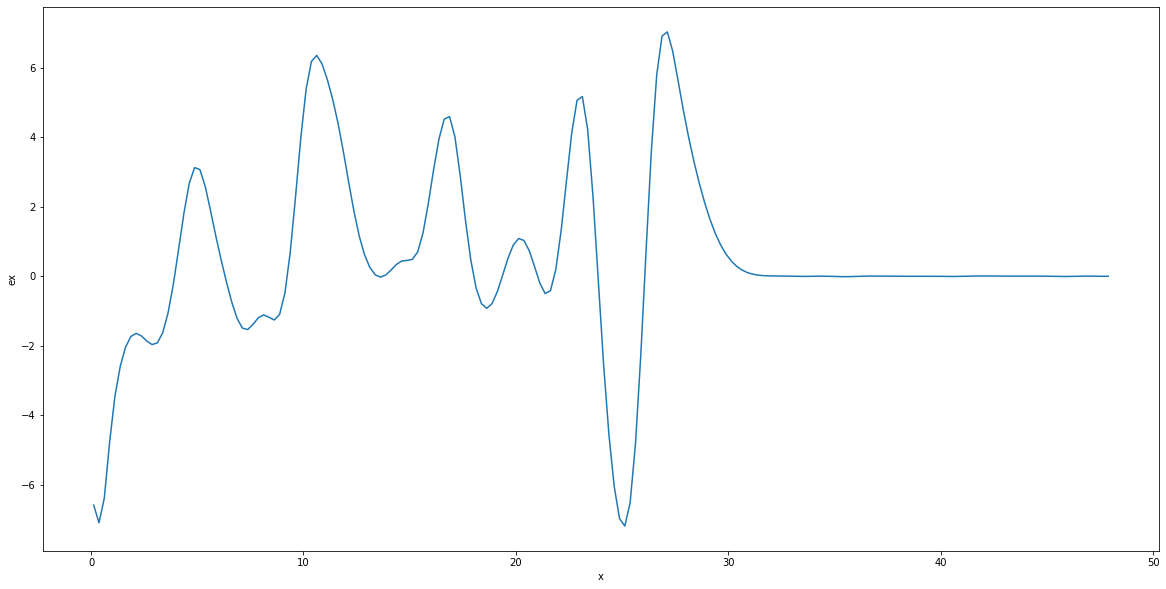

In [11]:
plot_field(dfields, 'ex')

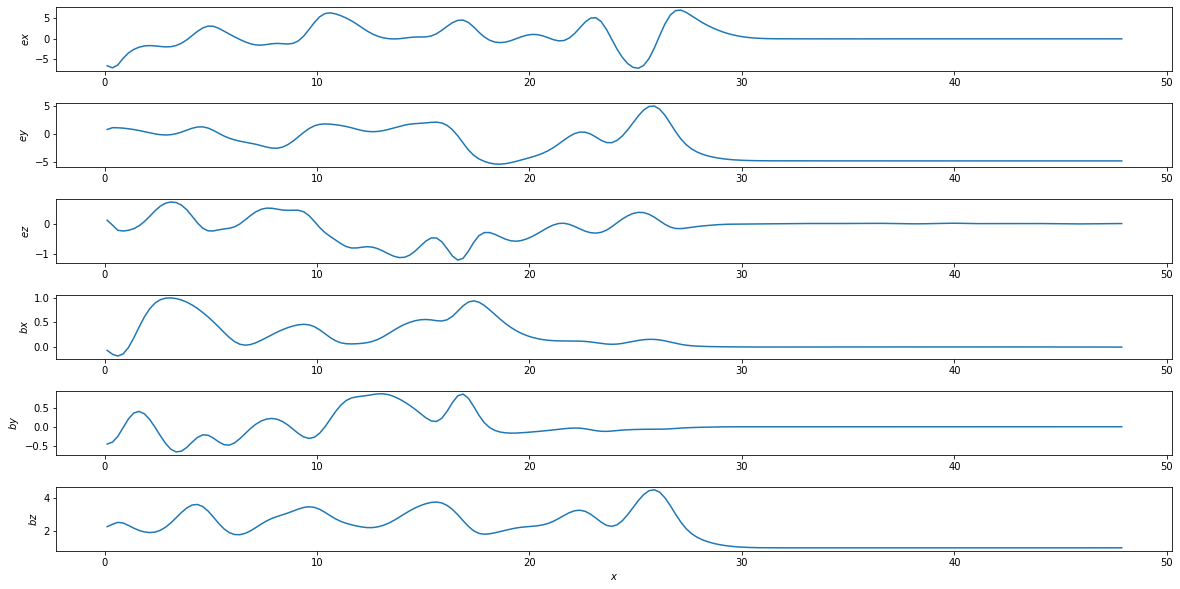

In [12]:
plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

## Analyze Fields


### Functions used to analyze fields

In [13]:
#finds the index of the two elements in an array closest to some given value
#assumes given array is ordered
def find_two_nearest(array, value):
    array = np.asarray(array)
    idx1 = (np.abs(array - value)).argmin()
    if(idx1 == 0): #if on left boundary
        idx2 = 1
    elif(idx1 == len(array)-1): #if on right boundary
        idx2 = len(array)-2
    elif(np.abs(array[idx1+1]-value) < np.abs(array[idx1-1]-value)):
        idx2 = idx1+1
    else:
        idx2 = idx1-1
    return idx1,idx2

In [14]:
# #returns weight for getting average field value within a cell 
# def get_3d_weights(xx,yy,zz,idxxx1,idxxx2,idxyy1,idxyy2,idxzz1,idxzz2,dfields,fieldkey):
#     #get weights by 'volume fraction' of cell
#     w1 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w2 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w3 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w4 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w5 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz1]-zz))
#     w6 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w7 = abs((dfields[fieldkey+'_xx'][idxxx1]-xx)*(dfields[fieldkey+'_yy'][idxyy2]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
#     w8 = abs((dfields[fieldkey+'_xx'][idxxx2]-xx)*(dfields[fieldkey+'_yy'][idxyy1]-yy)*(dfields[fieldkey+'_zz'][idxzz2]-zz))
    
#     #get volume
#     #Here we must find opposite corners of the box to ensure we get a 3d volume
#     #We find opposite corners by  sides of the box are all in either the xy,xz, or yz plane
#     #Note: this might only work when the cell walls are in the xy,xz,yz planes
#     maxxx = max(dfields[fieldkey+'_xx'][idxxx1],dfields[fieldkey+'_xx'][idxxx2])
#     maxyy = max(dfields[fieldkey+'_yy'][idxyy1],dfields[fieldkey+'_yy'][idxyy2])
#     maxzz = max(dfields[fieldkey+'_zz'][idxzz1],dfields[fieldkey+'_zz'][idxzz2])
#     minxx = min(dfields[fieldkey+'_xx'][idxxx1],dfields[fieldkey+'_xx'][idxxx2])
#     minyy = min(dfields[fieldkey+'_yy'][idxyy1],dfields[fieldkey+'_yy'][idxyy2])
#     minzz = min(dfields[fieldkey+'_zz'][idxzz1],dfields[fieldkey+'_zz'][idxzz2])
#     vol = abs((maxxx-minxx)*(maxyy-minyy)*(maxzz-minzz))
    
#     if(vol == 0.):
#         print("Error in getting weights! Found a zero volume.")
    
#     print(vol)
#     print(dfields[fieldkey+'_xx'][idxxx1]-xx)
#     print(dfields[fieldkey+'_xx'][idxxx1])
#     print(xx)
    
#     #normalize to one
#     w1 /= vol
#     w2 /= vol
#     w3 /= vol
#     w4 /= vol
#     w5 /= vol
#     w6 /= vol
#     w7 /= vol
#     w8 /= vol
    
#     #debug (should sum to 1)
#     if(True):
#         print('sum of weights: ' + str(w1+w2+w3+w4+w5+w6+w7+w8))
#         print(w1,w2,w3,w4,w5,w6,w7,w8)
        
#     return w1,w2,w3,w4,w5,w6,w7,w8

In [15]:
# #estimates the field at some point within a cell by taking a weighted average of the surronding grid points
# #NOTE: this assumes the sides of the box are all in either the xy,xz, or yz plane
# #TODO:FIX (weight is no longer 1?)
# def weighted_field_average(xx, yy, zz, dfields, fieldkey):
#     idxxx1, idxxx2 = find_two_nearest(dfields[fieldkey+'_xx'],xx)
#     idxyy1, idxyy2 = find_two_nearest(dfields[fieldkey+'_yy'],yy)
#     idxzz1, idxzz2 = find_two_nearest(dfields[fieldkey+'_zz'],zz)
    
#     #find weights
#     w1,w2,w3,w4,w5,w6,w7,w8 = get_3d_weights(xx,yy,zz,idxxx1,idxxx2,idxyy1,idxyy2,idxzz1,idxzz2,dfields,fieldkey)
    
    
#     #TODO: fix indexing here
#     #take average of field
#     fieldaverage = w1*dfields[fieldkey][idxzz1][idxyy1][idxxx1]
#     fieldaverage +=w2*dfields[fieldkey][idxzz1][idxyy1][idxxx2]
#     fieldaverage +=w3*dfields[fieldkey][idxzz1][idxyy2][idxxx1]
#     fieldaverage +=w4*dfields[fieldkey][idxzz2][idxyy1][idxxx1]
#     fieldaverage +=w5*dfields[fieldkey][idxzz1][idxyy2][idxxx2]
#     fieldaverage +=w6*dfields[fieldkey][idxzz2][idxyy2][idxxx2]
#     fieldaverage +=w7*dfields[fieldkey][idxzz2][idxyy2][idxxx1]
#     fieldaverage +=w8*dfields[fieldkey][idxzz2][idxyy1][idxxx2]
    
#     #debug
#     if(True):
#         print('fields:')
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print(dfields[fieldkey][idxzz1][idxyy1][idxxx1])
#         print('weights')
#         print(w1)
#         print(w2)
#         print(w3)
#         print(w4)
#         print(w5)
#         print(w6)
#         print(w7)
#         print(w8)
    
#     return fieldaverage

In [16]:
#makes distribution and takes correlation wrt given field
#WARNING: this will average the fields within the specified bounds. 
#However, if there are no gridpoints within the specified bounds
#it will *not* grab the field value at the nearest gridpoint and break. TODO: grab nearest field when range is small
def make2dHistandCey(vmax, dv, x1, x2, y1, y2, dpar, dfields, fieldkey):

    #find average E field based on provided bounds
    gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])  & (dfields[fieldkey+'_xx'] <= x2)
    gfieldptsy = (y1 <= dfields[fieldkey+'_yy']) & (dfields[fieldkey+'_yy'] <= y2)

    goodfieldpts = []
    for i in range(0,len(dfields['ex_xx'])):
        for j in range(0,len(dfields['ex_yy'])):
            for k in range(0,len(dfields['ex_zz'])):
                if(gfieldptsx[i] == True and gfieldptsy[j] == True):
                    goodfieldpts.append(dfields[fieldkey][k][j][i])
      
    #TODO?: consider forcing user to take correlation over only 1 cell
    if(len(goodfieldpts)==0):
        print("Using weighted_field_average...") #Debug
        avgfield = weighted_field_average((x1+x2)/2.,(y1+y2)/2.,0,dfields,fieldkey) #TODO: make 3d i.e. *don't* just 'project' all z information out and take fields at z = 0
    else:              
        avgfield = np.average(goodfieldpts)
    totalFieldpts = np.sum(goodfieldpts)

    #define mask that includes particles within range
    gptsparticle = (x1 < dpar['x1'] ) & (dpar['x1'] < x2) & (y1 < dpar['x2']) & (dpar['x2'] < y2)
    totalPtcl = np.sum(gptsparticle)
    
    #make bins
    vxbins = np.arange(-vmax, vmax, dv)
    vx = (vxbins[1:] + vxbins[:-1])/2.
    vybins = np.arange(-vmax, vmax, dv)
    vy = (vybins[1:] + vybins[:-1])/2.
    
    #make the bins 2d arrays
    _vx = np.zeros((len(vy),len(vx)))
    _vy = np.zeros((len(vy),len(vx)))
    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vx[i][j] = vx[j]

    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vy[i][j] = vy[i]

    vx = _vx
    vy = _vy
    
    #find distribution
    Hxy,_,_ = np.histogram2d(dpar['p2'][gptsparticle],dpar['p1'][gptsparticle],
                         bins=[vybins, vxbins])
    
    #calculate correlation
    Cey = -0.5*vy**2*np.gradient(Hxy, dv, edge_order=2, axis=0)*avgfield 
    return vx, vy, totalPtcl, totalFieldpts, Hxy, Cey

In [17]:
#makes distribution and takes correlation wrt given field
#WARNING: this will average the fields within the specified bounds. 
#However, if there are no gridpoints within the specified bounds
#it will *not* grab the field value at the nearest gridpoint and break. TODO: grab nearest field when range is small
def make2dHistandCex(vmax, dv, x1, x2, y1, y2, dpar, dfields, fieldkey):

    #find average E field based on provided bounds
    gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])  & (dfields[fieldkey+'_xx'] <= x2)
    gfieldptsy = (y1 <= dfields[fieldkey+'_yy']) & (dfields[fieldkey+'_yy'] <= y2)

    goodfieldpts = []
    for i in range(0,len(dfields['ex_xx'])):
        for j in range(0,len(dfields['ex_yy'])):
            for k in range(0,len(dfields['ex_zz'])):
                if(gfieldptsx[i] == True and gfieldptsy[j] == True):
                    goodfieldpts.append(dfields[fieldkey][k][j][i])
    
    if(len(goodfieldpts)==0):
        print("Warning, no field grid points in given box. Please increase box size or center around grid point.")
    
    avgfield = np.average(goodfieldpts)
    totalFieldpts = np.sum(goodfieldpts)

    #define mask that includes particles within range
    gptsparticle = (x1 < dpar['x1'] ) & (dpar['x1'] < x2) & (y1 < dpar['x2']) & (dpar['x2'] < y2)
    totalPtcl = np.sum(gptsparticle)
    
    #make bins
    vxbins = np.arange(-vmax, vmax, dv)
    vx = (vxbins[1:] + vxbins[:-1])/2.
    vybins = np.arange(-vmax, vmax, dv)
    vy = (vybins[1:] + vybins[:-1])/2.
    
    #make the bins 2d arrays
    _vx = np.zeros((len(vy),len(vx)))
    _vy = np.zeros((len(vy),len(vx)))
    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vx[i][j] = vx[j]

    for i in range(0,len(vy)):
        for j in range(0,len(vx)):
            _vy[i][j] = vy[i]

    vx = _vx
    vy = _vy
    
    #find distribution
    Hxy,_,_ = np.histogram2d(dpar['p2'][gptsparticle],dpar['p1'][gptsparticle],
                         bins=[vybins, vxbins])
    
    #calculate correlation
    Cex = -0.5*vx**2*np.gradient(Hxy, dv, edge_order=2, axis=1)*avgfield
    return vx, vy, totalPtcl, totalFieldpts, Hxy, Cex

In [18]:
vmax

15.0

In [19]:
xShock = 27.0 

#calculate CEy correlation along entire shock front
if(printruntime):
    start_time = time.time()
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xShock, xShock+dx, 0, max(dfields['ey_yy']), dparticles, dfields, 'ey')
if(printruntime):
    print("Time to run correlation: %s seconds " % (time.time() - start_time))

Time to run correlation: 20.145566940307617 seconds 


## Plot FPCs/ Velocity Space Signatures
This section is mostly used for debugging purposes

In [20]:
def plot_velsig(vx,vy,vmax,Ce,fieldkey,flnm = '',ttl=''):
    plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

    maxCe = max(np.max(Ce),np.max(abs(Ce)))
    
    #ordering when plotting is flipped
    #see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
    plotv1 = vx#np.flip(vx)
    plotv2 = vy#np.flip(vy)
    
    plt.figure(figsize=(6.5,6))
    plt.figure(figsize=(6.5,6))
    plt.pcolormesh(plotv1, plotv2, Ce, vmax=maxCe, vmin=-maxCe, cmap="seismic", shading="gouraud")
    plt.xlim(-vmax, vmax)
    plt.ylim(-vmax, vmax)
    plt.xticks(np.linspace(-vmax, vmax, 9))
    plt.yticks(np.linspace(-vmax, vmax, 9))
    plt.title(ttl+" $C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
    plt.xlabel(r"$v_x/v_{ti}$")
    plt.ylabel(r"$v_y/v_{ti}$")
    plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
    clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
    plt.setp(plt.gca(), aspect=1.0)
    plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
    if(flnm != ''):
        plt.savefig(flnm+'.png',format='png')
        plt.close('all')#saves RAM
    else:
        plt.show()
    plt.close()

In [21]:
np.flip(vy)

array([[ 14.625,  14.625,  14.625, ...,  14.625,  14.625,  14.625],
       [ 14.375,  14.375,  14.375, ...,  14.375,  14.375,  14.375],
       [ 14.125,  14.125,  14.125, ...,  14.125,  14.125,  14.125],
       ...,
       [-14.375, -14.375, -14.375, ..., -14.375, -14.375, -14.375],
       [-14.625, -14.625, -14.625, ..., -14.625, -14.625, -14.625],
       [-14.875, -14.875, -14.875, ..., -14.875, -14.875, -14.875]])

<Figure size 468x432 with 0 Axes>

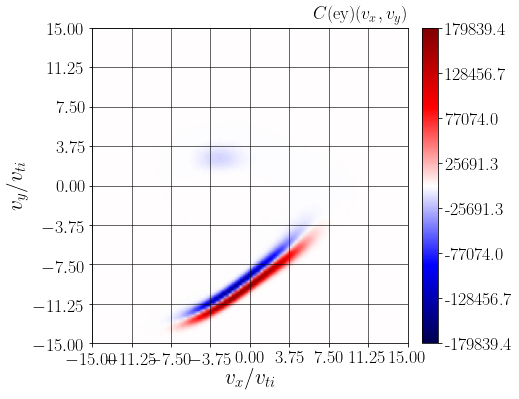

In [22]:
plot_velsig(vx,vy,vmax,Cey_quarterdi,'ey')

In [23]:
vx

array([[-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625],
       [-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625],
       [-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625],
       ...,
       [-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625],
       [-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625],
       [-14.875, -14.625, -14.375, ...,  14.125,  14.375,  14.625]])

In [24]:
vy

array([[-14.875, -14.875, -14.875, ..., -14.875, -14.875, -14.875],
       [-14.625, -14.625, -14.625, ..., -14.625, -14.625, -14.625],
       [-14.375, -14.375, -14.375, ..., -14.375, -14.375, -14.375],
       ...,
       [ 14.125,  14.125,  14.125, ...,  14.125,  14.125,  14.125],
       [ 14.375,  14.375,  14.375, ...,  14.375,  14.375,  14.375],
       [ 14.625,  14.625,  14.625, ...,  14.625,  14.625,  14.625]])

In [25]:
print(Cey_quarterdi)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Do sample bulk analysis along all x slices

In [26]:
#define attributes/ simulation parameters
params = {}
params["MachAlfven"] = float('nan')
params["MachAlfvenNote"] = 'TODO: compute mach alfven for this run'
params["ShockNormalAngle"] = 0.0
params["betaelec"] = 1.0
params["betaion"] = 1.0
params["simtime"] = 1000
params["simtimeNote"] = 'This is frames number for this data set. TODO: convert to inverse Omega_c,i'
params["qi"] = 1.0
params["di"] = 0.0
params["dinote"] = 'TODO: compute ion inertial length'
params["vti"] = 1.0

In [27]:
xShock = 27.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
vmax = 16.0

#analyze along 3 slices near shock
CEx_out = []
CEy_out = []
x_out = []

Hxy_out = []

#to do full 'bulk analysis' we loop over one of these three blocks for all desired sections along x
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xShock, xShock+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, 'ey')
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cex_quarterdi = make2dHistandCex(vmax, dv, xShock, xShock+dx, dfields['ex_xx'][0], dfields['ex_xx'][1], dparticles, dfields, 'ex')
x_out.append(np.mean([xShock,xShock+dx]))
CEy_out.append(Cey_quarterdi)
CEx_out.append(Cex_quarterdi)
Hxy_out.append(Hxy_quarterdi)
xShock+=dx

vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xShock, xShock+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, 'ey')
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cex_quarterdi = make2dHistandCex(vmax, dv, xShock, xShock+dx, dfields['ex_xx'][0], dfields['ex_xx'][1], dparticles, dfields, 'ex')
x_out.append(np.mean([xShock,xShock+dx]))
CEy_out.append(Cey_quarterdi)
CEx_out.append(Cex_quarterdi)
Hxy_out.append(Hxy_quarterdi)
xShock+=dx

vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xShock, xShock+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, 'ey')
vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cex_quarterdi = make2dHistandCex(vmax, dv, xShock, xShock+dx, dfields['ex_xx'][0], dfields['ex_xx'][1], dparticles, dfields, 'ex')
x_out.append(np.mean([xShock,xShock+dx]))
CEy_out.append(Cey_quarterdi)
CEx_out.append(Cex_quarterdi)
Hxy_out.append(Hxy_quarterdi)
xShock+=dx

## Make Plots

<Figure size 468x432 with 0 Axes>

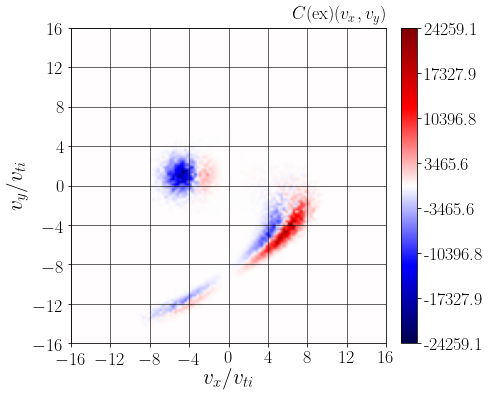

In [28]:
plot_velsig(vx,vy,vmax,CEx_out[0],'ex')

<Figure size 468x432 with 0 Axes>

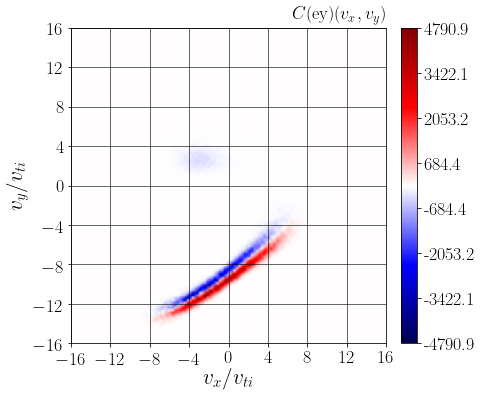

In [29]:
plot_velsig(vx,vy,vmax,CEy_out[0],'ey')

### Plot fields and distribution of above plots for debug of analysis
#### Mostly trying to figure out the ordering

<Figure size 468x432 with 0 Axes>

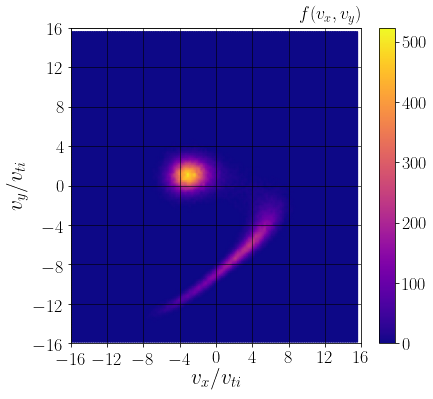

In [30]:
#Plot distribution
plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

plt.figure(figsize=(6.5,6))
plt.figure(figsize=(6.5,6))
plt.pcolormesh(vx, vy, Hxy_out[0], cmap="plasma", shading="gouraud")
plt.xlim(-vmax, vmax)
plt.ylim(-vmax, vmax)
plt.xticks(np.linspace(-vmax, vmax, 9))
plt.yticks(np.linspace(-vmax, vmax, 9))
plt.title(r"$f(v_x, v_y)$",loc="right")
plt.xlabel(r"$v_x/v_{ti}$")
plt.ylabel(r"$v_y/v_{ti}$")
plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
#clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
plt.colorbar()
#plt.setp(plt.gca(), aspect=1.0)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
plt.show()
plt.close()

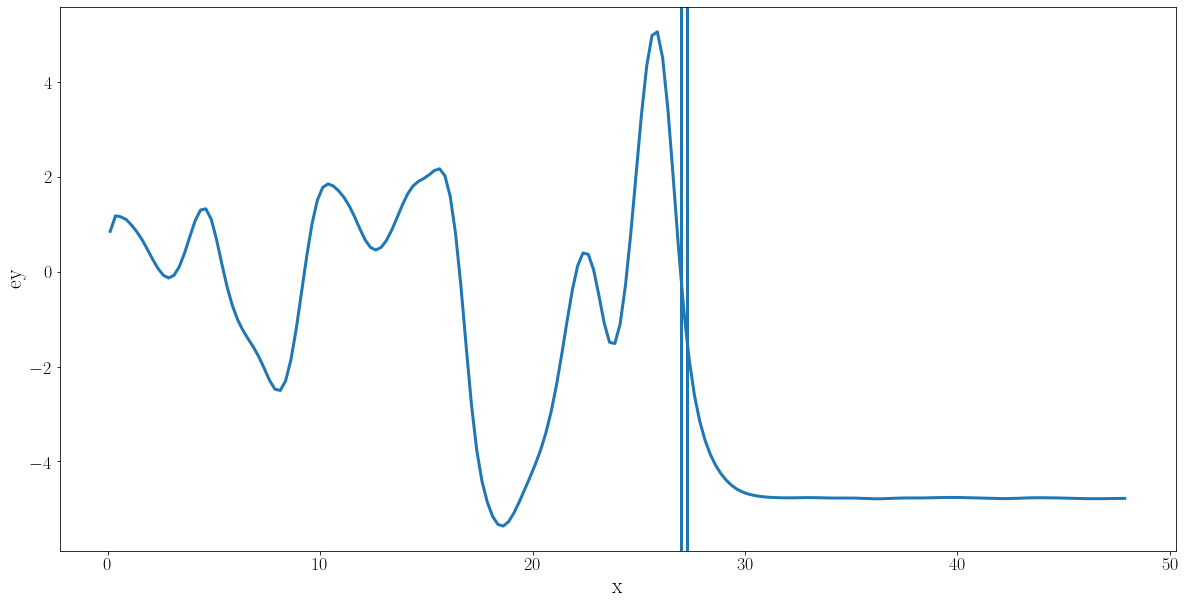

In [31]:
axis='_xx'
fieldkey = 'ey'
yyindex = 0
zzindex = 0
xShock = 27.0
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

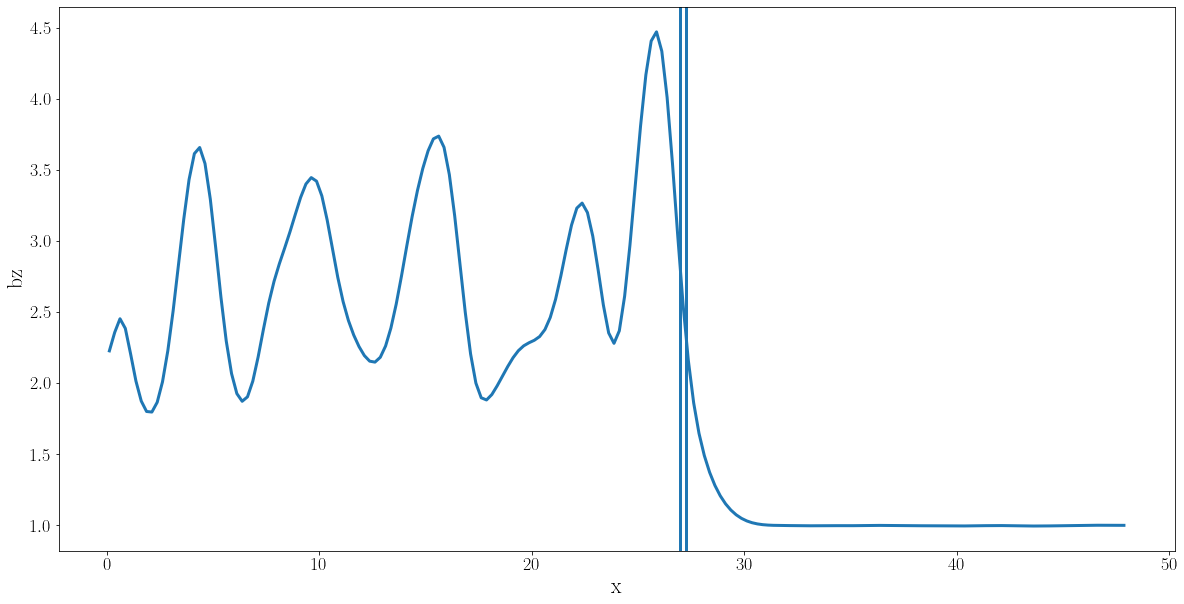

In [32]:
axis='_xx'
fieldkey = 'bz'
yyindex = 1
zzindex = 1
xShock = 27.0
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

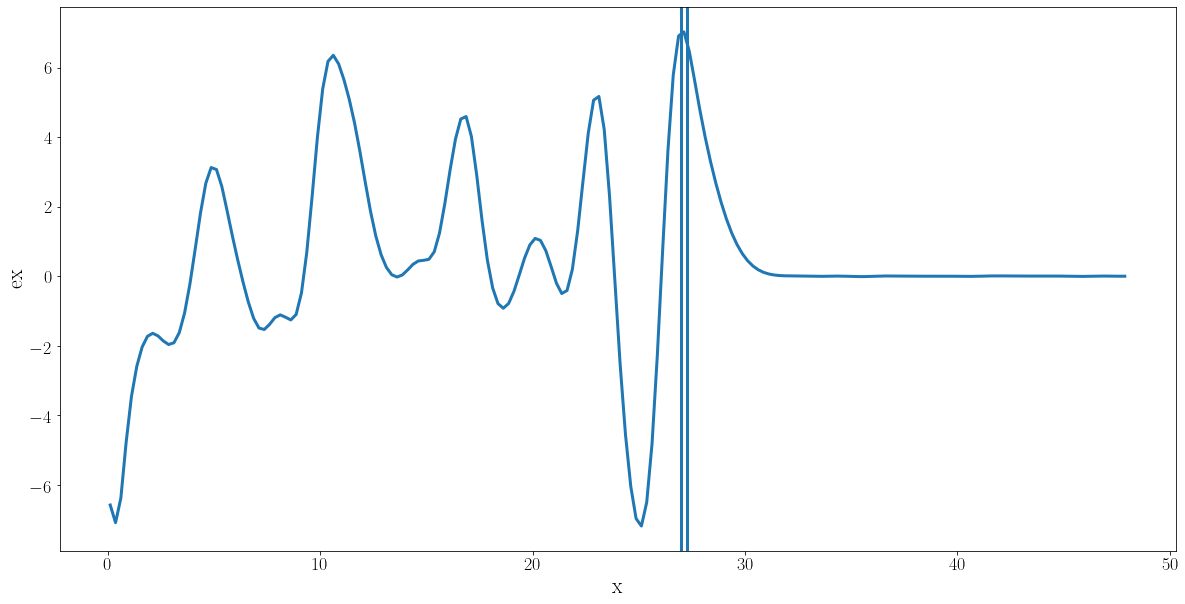

In [33]:
axis='_xx'
fieldkey = 'ex'
yyindex = 0
zzindex = 0
xShock = 27.0
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

In [34]:
#box size
xsize = dx
ysize = abs(dfields['ey_yy'][0]-dfields['ey_yy'][1])
zsize = abs(dfields['ey_zz'][0]-dfields['ey_zz'][len(dfields['ey_zz'])-1])
print(xsize)
print(ysize)
print(zsize)

0.25
0.25
11.75


In [35]:
abs(dfields['ey_xx'][0]-dfields['ey_xx'][1])

0.25

In [149]:
#take average of fields to report what was used in the correlation
#TODO: remove vmax and dv and dpar
#TODO: make 3d
def getfieldaverageinbox(vmax, dv, x1, x2, y1, y2, dpar, dfields, fieldkey):

    #find average field based on provided bounds
    gfieldptsx = (x1 <= dfields[fieldkey+'_xx'])  & (dfields[fieldkey+'_xx'] <= x2)
    gfieldptsy = (y1 <= dfields[fieldkey+'_yy']) & (dfields[fieldkey+'_yy'] <= y2)

    goodfieldpts = []
    for i in range(0,len(dfields['ex_xx'])):
        for j in range(0,len(dfields['ex_yy'])):
            for k in range(0,len(dfields['ex_zz'])):
                if(gfieldptsx[i] == True and gfieldptsy[j] == True):
                    goodfieldpts.append(dfields[fieldkey][k][j][i])
   

    #debug
    print("numgridpts sampled: " + str(len(goodfieldpts)))
    
    
    avgfield = np.average(goodfieldpts)
    return avgfield

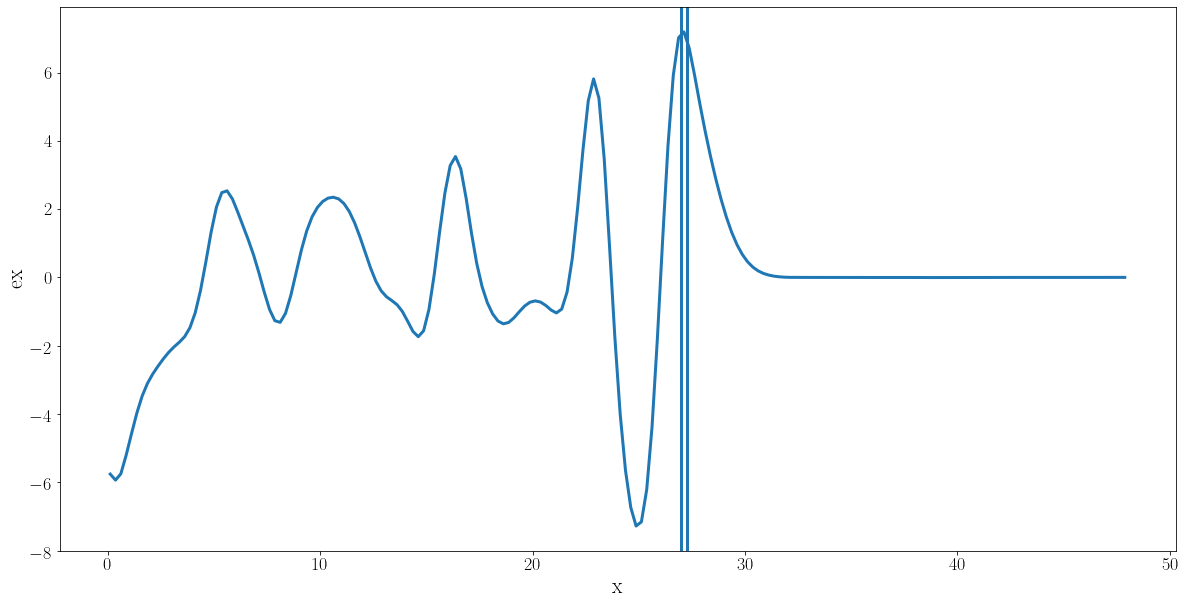

In [37]:
axis='_xx'
fieldkey = 'ex'
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]

fieldvals = []
xtemp=0.
for i in range(0,len(dfields['ex_xx'])):
    fieldvals.append(getfieldaverageinbox(vmax, dv, xtemp, xtemp+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, fieldkey))
    xtemp+=dx
    
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldvals)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

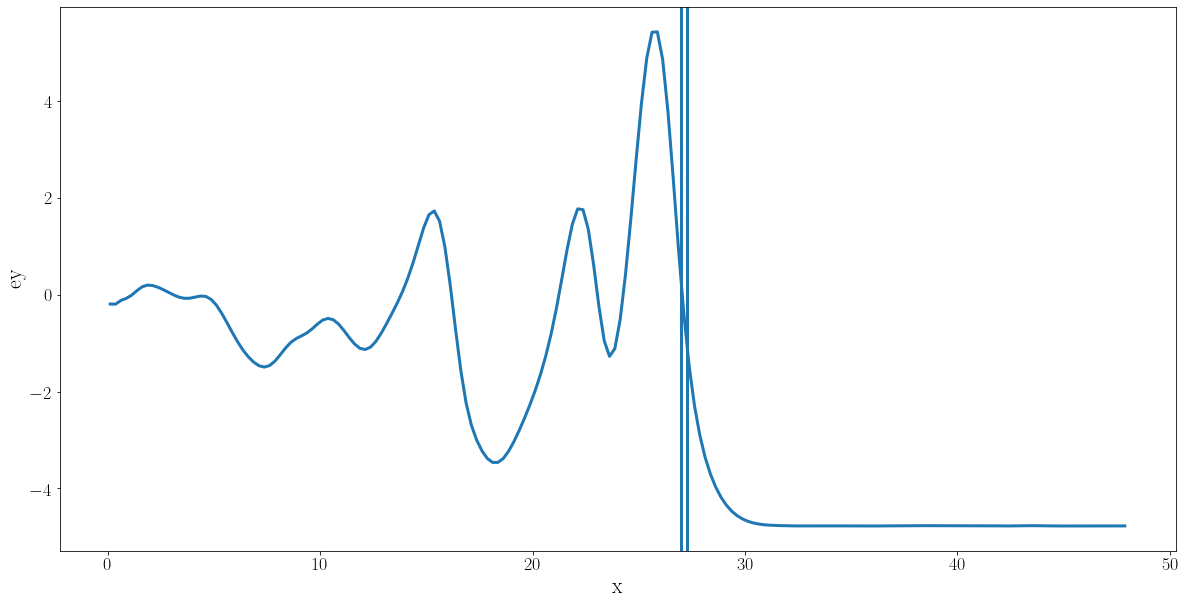

In [38]:
axis='_xx'
fieldkey = 'ey'
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]

fieldvals = []
xtemp=0.
for i in range(0,len(dfields['ex_xx'])):
    fieldvals.append(getfieldaverageinbox(vmax, dv, xtemp, xtemp+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, fieldkey))
    xtemp+=dx
    
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldvals)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

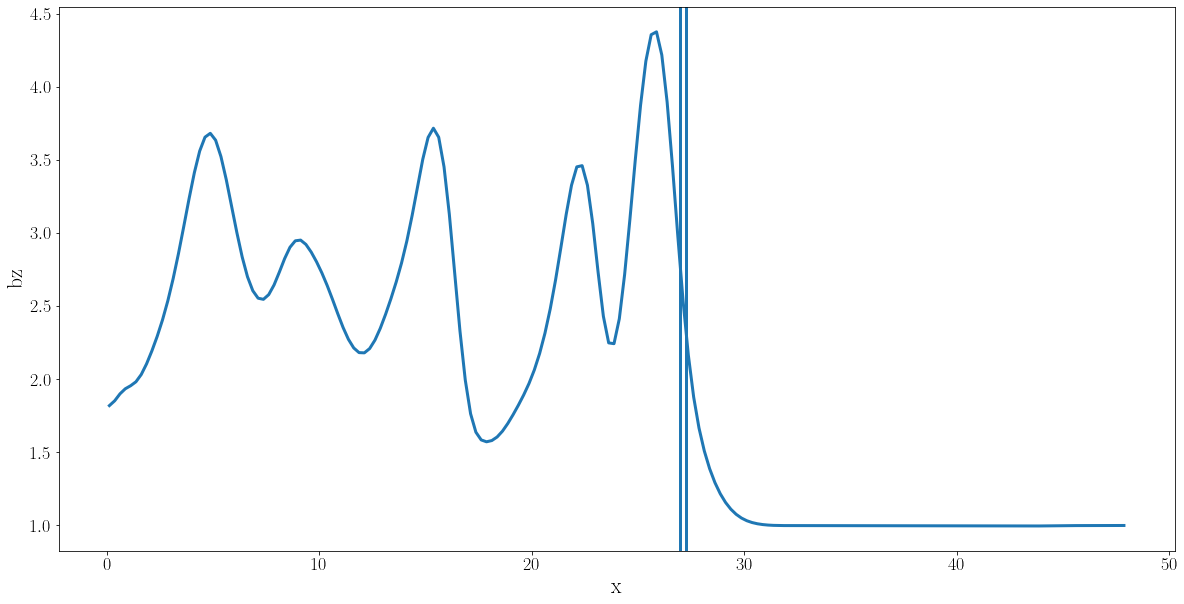

In [39]:
axis='_xx'
fieldkey = 'bz'
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]

fieldvals = []
xtemp=0.
for i in range(0,len(dfields['ex_xx'])):
    fieldvals.append(getfieldaverageinbox(vmax, dv, xtemp, xtemp+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, fieldkey))
    xtemp+=dx
    
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldvals)
plt.axvline(x=xShock)
plt.axvline(x=xShock+dx)
plt.show()

In [40]:
#color plot mesh to try and figure out orientation
def makefieldpmesh(dfields,fieldkey,planename):
    if(planename=='xy'):
        ttl = fieldkey+'(x,y)'
        xlbl = 'x (di)'
        ylbl = 'y (di)'
        fieldpmesh = np.mean(dfields[fieldkey],axis=0)
        xplot1d = dfields[fieldkey+'_xx'][:]
        yplot1d = dfields[fieldkey+'_yy'][:]

    elif(planename=='xz'):
        ttl = fieldkey+'(x,z)'
        xlbl = 'x (di)'
        ylbl = 'z (di)'
        fieldpmesh = np.mean(dfields[fieldkey],axis=1)
        xplot1d = dfields[fieldkey+'_xx'][:]
        yplot1d = dfields[fieldkey+'_zz'][:]


        
    elif(planename=='yz'):
        ttl = fieldkey+'(y,z)'
        xlbl = 'y (di)'
        ylbl = 'z (di)'
        fieldpmesh = np.mean(dfields[fieldkey],axis=2)
        xplot1d = dfields[fieldkey+'_yy'][:]
        yplot1d = dfields[fieldkey+'_zz'][:]

    #make 2d arrays for more explicit plotting
    xplot = np.zeros((len(yplot1d),len(xplot1d)))
    yplot = np.zeros((len(yplot1d),len(xplot1d)))
    for i in range(0,len(yplot1d)):
        for j in range(0,len(xplot1d)):
            xplot[i][j] = xplot1d[j]

    for i in range(0,len(yplot1d)):
        for j in range(0,len(xplot1d)):
            yplot[i][j] = yplot1d[i]
    
    plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots
    plt.figure(figsize=(6.5,6))
    plt.figure(figsize=(6.5,6))
    plt.pcolormesh(xplot, yplot, fieldpmesh, cmap="inferno", shading="gouraud")
#     plt.xlim(-, )
#     plt.ylim(-, )
#     plt.xticks(np.linspace(-8, 8, 9))
#     plt.yticks(np.linspace(-8, 8, 9))
    plt.title(ttl,loc="right")
    plt.xlabel(xlbl)
    plt.ylabel(ylbl)
    plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
    #clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
    plt.colorbar()
    #plt.setp(plt.gca(), aspect=1.0)
    plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
    plt.show()
    plt.close()

<Figure size 468x432 with 0 Axes>

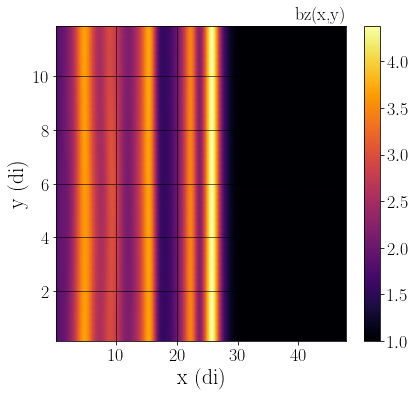

In [41]:
makefieldpmesh(dfields,'bz','xy')

<Figure size 468x432 with 0 Axes>

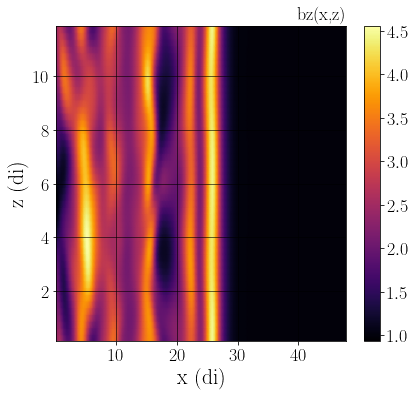

In [42]:
makefieldpmesh(dfields,'bz','xz')

<Figure size 468x432 with 0 Axes>

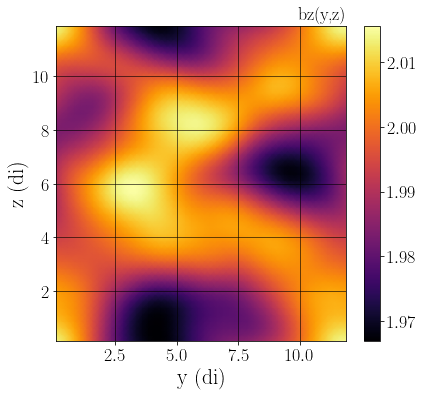

In [43]:
makefieldpmesh(dfields,'bz','yz')

## Do full bulk analysis

In [44]:
xsweep = 0.0
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0]
dv = 0.25

CEx_out = []
CEy_out = []
x_out = []
Hxy_out = []

for i in range(0,len(dfields['ex_xx'])):
    print(str(dfields['ex_xx'][i]) +' of ' + str(dfields['ex_xx'][len(dfields['ex_xx'])-1]))
    #to do full 'bulk analysis' we loop over one of these three blocks for all desired sections along x
    vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cey_quarterdi = make2dHistandCey(vmax, dv, xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1], dparticles, dfields, 'ey')
    vx, vy, totalPtcl_quarterdi, totalFieldpts, Hxy_quarterdi, Cex_quarterdi = make2dHistandCex(vmax, dv, xsweep, xsweep+dx, dfields['ex_xx'][0], dfields['ex_xx'][1], dparticles, dfields, 'ex')
    x_out.append(np.mean([xsweep,xsweep+dx]))
    CEy_out.append(Cey_quarterdi)
    CEx_out.append(Cex_quarterdi)
    Hxy_out.append(Hxy_quarterdi)
    xsweep+=dx

0.125 of 47.875
0.375 of 47.875
0.625 of 47.875
0.875 of 47.875
1.125 of 47.875
1.375 of 47.875
1.625 of 47.875
1.875 of 47.875
2.125 of 47.875
2.375 of 47.875
2.625 of 47.875
2.875 of 47.875
3.125 of 47.875
3.375 of 47.875
3.625 of 47.875
3.875 of 47.875
4.125 of 47.875
4.375 of 47.875
4.625 of 47.875
4.875 of 47.875
5.125 of 47.875
5.375 of 47.875
5.625 of 47.875
5.875 of 47.875
6.125 of 47.875
6.375 of 47.875
6.625 of 47.875
6.875 of 47.875
7.125 of 47.875
7.375 of 47.875
7.625 of 47.875
7.875 of 47.875
8.125 of 47.875
8.375 of 47.875
8.625 of 47.875
8.875 of 47.875
9.125 of 47.875
9.375 of 47.875
9.625 of 47.875
9.875 of 47.875
10.125 of 47.875
10.375 of 47.875
10.625 of 47.875
10.875 of 47.875
11.125 of 47.875
11.375 of 47.875
11.625 of 47.875
11.875 of 47.875
12.125 of 47.875
12.375 of 47.875
12.625 of 47.875
12.875 of 47.875
13.125 of 47.875
13.375 of 47.875
13.625 of 47.875
13.875 of 47.875
14.125 of 47.875
14.375 of 47.875
14.625 of 47.875
14.875 of 47.875
15.125 of 47.875
15.

## Make Netcdf4 file
Be careful that orientation is preserved. Make sure to check this (see above field plots)

#### Determine bounds for metadata = 1

In [45]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

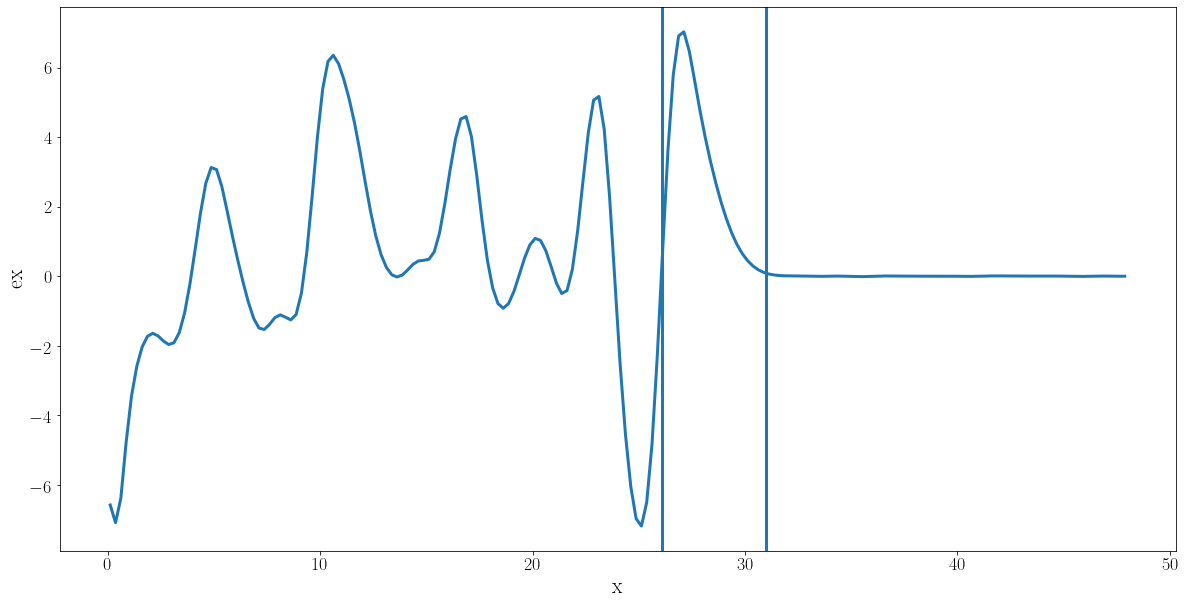

In [46]:
axis='_xx'
fieldkey = 'ex'
yyindex = 0
zzindex = 0
startval = 26.1 #bounds for metadata = 1 (di)
endval = 31 #bounds for metadata = 1 (di)
dx = dfields[fieldkey+axis][1]-dfields[fieldkey+axis][0]

fieldval = np.asarray([dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))])
xlbl = 'x'

fieldcoord = np.asarray(dfields[fieldkey+axis])

plt.figure(figsize=(20,10))
plt.xlabel(xlbl)
plt.ylabel(fieldkey)
plt.plot(fieldcoord,fieldval)
plt.axvline(x=startval)
plt.axvline(x=endval)
plt.show()

In [47]:
startidx = find_nearest(dfields[fieldkey+axis], startval)

In [48]:
endidx = find_nearest(dfields[fieldkey+axis], endval)

In [49]:
metadata = np.zeros(len(dfields['ex_xx']))
metadata = metadata.astype(int)
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [50]:
for i in range(0,len(metadata)):
    if(i >= startidx and i <= endidx):
        metadata[i] = 1
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [164]:
startidx

104

In [166]:
endidx

123

In [82]:
def savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = {}, filename = 'dHybridRSDAtest.nc' ):
    from netCDF4 import Dataset
    from datetime import datetime
    
    
    #normalize CEx, CEy to 1-------------------------------------------------------
    #Here we normalize to the maximum value in either CEx, CEy
    maxCval = max(np.amax(np.abs(CEx_out)),np.amax(np.abs(CEy_out)))
    CEx_out /= maxCval
    CEy_out /= maxCval
    

    # open a netCDF file to write
    ncout = Dataset(filename, 'w', format='NETCDF4')
    
        
    #save data in netcdf file-------------------------------------------------------
    #define attributes
    for key in params:
        setattr(ncout,key,params[key])
    ncout.description = 'dHybridR MLA data test 1'
    ncout.generationtime = str(datetime.now())

    #make dimensions that dependent data must 'match'
    ncout.createDimension('x', None)  # NONE <-> unlimited TODO: make limited if it saves memory or improves compression?
    ncout.createDimension('vx', None)
    ncout.createDimension('vy', None)
    
    vx = ncout.createVariable('vx','f4', ('vx',))
    vx.nvx = len(vx_out)
    vx.longname = 'v_x/v_ti'
    vx[:] = vx_out[:]
    
    vy = ncout.createVariable('vy','f4', ('vy',))
    vy.nvy = len(vy_out)
    vy.longname = 'v_y/v_ti'
    vy[:] = vy_out[:]

    x = ncout.createVariable('x','f4',('x',))
    x.nx = len(x_out)
    x[:] = x_out[:]

    #tranpose data to match previous netcdf4 formatting
    for i in range(0,len(CEx_out)):
        tempCex = CEx_out[i].T
        CEx_out[i] = tempCex
        tempCey = CEy_out[i].T
        CEy_out[i] = tempCey
    
    C_ex = ncout.createVariable('C_Ex','f4', ('x', 'vx', 'vy'))
    C_ex.longname = 'C_{Ex}'
    C_ex[:] = CEx_out[:]

    C_ey = ncout.createVariable('C_Ey','f4', ('x', 'vx', 'vy'))
    C_ey.longname = 'C_{Ey}'
    C_ey[:] = CEy_out[:]
    
    metadata = ncout.createVariable('metadata','f4',('x',))
    metadata.description = '1 = signature, 0 = no signature'
    metadata[:] = metadata_out[:]
    
    #Save data into netcdf4 file-----------------------------------------------------
    print("Saving data into netcdf4 file")

    #save file
    ncout.close()


In [83]:
vx[0][:]

array([-15.875, -15.625, -15.375, -15.125, -14.875, -14.625, -14.375,
       -14.125, -13.875, -13.625, -13.375, -13.125, -12.875, -12.625,
       -12.375, -12.125, -11.875, -11.625, -11.375, -11.125, -10.875,
       -10.625, -10.375, -10.125,  -9.875,  -9.625,  -9.375,  -9.125,
        -8.875,  -8.625,  -8.375,  -8.125,  -7.875,  -7.625,  -7.375,
        -7.125,  -6.875,  -6.625,  -6.375,  -6.125,  -5.875,  -5.625,
        -5.375,  -5.125,  -4.875,  -4.625,  -4.375,  -4.125,  -3.875,
        -3.625,  -3.375,  -3.125,  -2.875,  -2.625,  -2.375,  -2.125,
        -1.875,  -1.625,  -1.375,  -1.125,  -0.875,  -0.625,  -0.375,
        -0.125,   0.125,   0.375,   0.625,   0.875,   1.125,   1.375,
         1.625,   1.875,   2.125,   2.375,   2.625,   2.875,   3.125,
         3.375,   3.625,   3.875,   4.125,   4.375,   4.625,   4.875,
         5.125,   5.375,   5.625,   5.875,   6.125,   6.375,   6.625,
         6.875,   7.125,   7.375,   7.625,   7.875,   8.125,   8.375,
         8.625,   8.

In [84]:
np.asarray([vy[i][0] for i in range(0,len(vy))])

array([-15.875, -15.625, -15.375, -15.125, -14.875, -14.625, -14.375,
       -14.125, -13.875, -13.625, -13.375, -13.125, -12.875, -12.625,
       -12.375, -12.125, -11.875, -11.625, -11.375, -11.125, -10.875,
       -10.625, -10.375, -10.125,  -9.875,  -9.625,  -9.375,  -9.125,
        -8.875,  -8.625,  -8.375,  -8.125,  -7.875,  -7.625,  -7.375,
        -7.125,  -6.875,  -6.625,  -6.375,  -6.125,  -5.875,  -5.625,
        -5.375,  -5.125,  -4.875,  -4.625,  -4.375,  -4.125,  -3.875,
        -3.625,  -3.375,  -3.125,  -2.875,  -2.625,  -2.375,  -2.125,
        -1.875,  -1.625,  -1.375,  -1.125,  -0.875,  -0.625,  -0.375,
        -0.125,   0.125,   0.375,   0.625,   0.875,   1.125,   1.375,
         1.625,   1.875,   2.125,   2.375,   2.625,   2.875,   3.125,
         3.375,   3.625,   3.875,   4.125,   4.375,   4.625,   4.875,
         5.125,   5.375,   5.625,   5.875,   6.125,   6.375,   6.625,
         6.875,   7.125,   7.375,   7.625,   7.875,   8.125,   8.375,
         8.625,   8.

In [85]:
vx[0][:]

array([-15.875, -15.625, -15.375, -15.125, -14.875, -14.625, -14.375,
       -14.125, -13.875, -13.625, -13.375, -13.125, -12.875, -12.625,
       -12.375, -12.125, -11.875, -11.625, -11.375, -11.125, -10.875,
       -10.625, -10.375, -10.125,  -9.875,  -9.625,  -9.375,  -9.125,
        -8.875,  -8.625,  -8.375,  -8.125,  -7.875,  -7.625,  -7.375,
        -7.125,  -6.875,  -6.625,  -6.375,  -6.125,  -5.875,  -5.625,
        -5.375,  -5.125,  -4.875,  -4.625,  -4.375,  -4.125,  -3.875,
        -3.625,  -3.375,  -3.125,  -2.875,  -2.625,  -2.375,  -2.125,
        -1.875,  -1.625,  -1.375,  -1.125,  -0.875,  -0.625,  -0.375,
        -0.125,   0.125,   0.375,   0.625,   0.875,   1.125,   1.375,
         1.625,   1.875,   2.125,   2.375,   2.625,   2.875,   3.125,
         3.375,   3.625,   3.875,   4.125,   4.375,   4.625,   4.875,
         5.125,   5.375,   5.625,   5.875,   6.125,   6.375,   6.625,
         6.875,   7.125,   7.375,   7.625,   7.875,   8.125,   8.375,
         8.625,   8.

In [86]:
np.asarray([vy[i][0] for i in range(0,len(vy))])

array([-15.875, -15.625, -15.375, -15.125, -14.875, -14.625, -14.375,
       -14.125, -13.875, -13.625, -13.375, -13.125, -12.875, -12.625,
       -12.375, -12.125, -11.875, -11.625, -11.375, -11.125, -10.875,
       -10.625, -10.375, -10.125,  -9.875,  -9.625,  -9.375,  -9.125,
        -8.875,  -8.625,  -8.375,  -8.125,  -7.875,  -7.625,  -7.375,
        -7.125,  -6.875,  -6.625,  -6.375,  -6.125,  -5.875,  -5.625,
        -5.375,  -5.125,  -4.875,  -4.625,  -4.375,  -4.125,  -3.875,
        -3.625,  -3.375,  -3.125,  -2.875,  -2.625,  -2.375,  -2.125,
        -1.875,  -1.625,  -1.375,  -1.125,  -0.875,  -0.625,  -0.375,
        -0.125,   0.125,   0.375,   0.625,   0.875,   1.125,   1.375,
         1.625,   1.875,   2.125,   2.375,   2.625,   2.875,   3.125,
         3.375,   3.625,   3.875,   4.125,   4.375,   4.625,   4.875,
         5.125,   5.375,   5.625,   5.875,   6.125,   6.375,   6.625,
         6.875,   7.125,   7.375,   7.625,   7.875,   8.125,   8.375,
         8.625,   8.

In [88]:
#note: it seems jupyter does not have permission to overwrite files. Either change filename or delete conflicting file
#metadata = [1,1,1] #TODO: ID where shock is and set metadeta 
flnm = 'test3.nc'
savedata(CEx_out,CEy_out,vx[0][:],np.asarray([vy[i][0] for i in range(0,len(vy))]),x_out,metadata_out=metadata,params=params,filename=flnm) #assumes uniform velocity grid

Saving data into netcdf4 file


## Make movie of CEx, CEy

In [ ]:
#make test png
plot_velsig(vx,vy,vmax,CEx_out[0],'ex',flnm = 'testCExoutpng',ttl='x(di): '+str(x_out[0]))

In [ ]:
#make a bunch of pngs
for i in range(0,len(CEx_out)):
    print(str(i)+' of '+str(len(CEx_out)))
    ttlCEx = 'graphsCEx/'+'CEx'+str(i).zfill(3)
    ttlCEy = 'graphsCEy/'+'CEy'+str(i).zfill(3)
    plot_velsig(vx,vy,vmax,CEx_out[i],'ex',flnm = ttlCEx,ttl='x(di): '+str(x_out[i]))
    plot_velsig(vx,vy,vmax,CEy_out[i],'ey',flnm = ttlCEy,ttl='x(di): '+str(x_out[i]))


In [ ]:
import os
filenames =  os.listdir('/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/testcolbyscript/graphsCEy/')
filenames = sorted(filenames)
filenames = filenames[1:] #quick way to remove .DS_store
filenames

In [ ]:
#make gif
import imageio
import os
images = []
directory = '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/testcolbyscript/graphsCEx/'
filenames =  os.listdir(directory)
filenames = sorted(filenames)
filenames = filenames[1:] #quick way to remove .DS_store
for filename in filenames:
    images.append(imageio.imread(directory+filename))
imageio.mimsave('CEx.gif', images)

In [ ]:
#make gif
import imageio
import os
images = []
directory = '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/testcolbyscript/graphsCEy/'
filenames =  os.listdir(directory)
filenames = sorted(filenames)
filenames = filenames[1:] #quick way to remove .DS_store
for filename in filenames:
    images.append(imageio.imread(directory+filename))
imageio.mimsave('CEy.gif', images)

In [81]:
#show movies

<img src="CEx.gif" width="750" align="center">

<img src="CEy.gif" width="750" align="center">

## Debug Area

In [ ]:
vy

In [ ]:
dfields['ex_xx']

In [ ]:
dx

In [ ]:
goodfieldpts = []

In [ ]:
type(goodfieldpts)

### Test np.gradient

In [ ]:
import numpy as np


In [ ]:
A = []
n = 10
for k in range(0,n):
    A.append(np.arange(0,n))
A = np.asarray(A)
A

In [ ]:
dx = 1.
np.gradient(A, dx, edge_order=2, axis=1)
#First index corresponds to x. Second to y

### Figure out how to make 3d distributions
##### Currently, I'm only convinced that xy plane is functional, which is all we need for now. Other planes may be functional but still need to be chck TODO: check xz yz

In [ ]:
#make a distribution that is sinusodial in xx, linear in yy, and parabolic in zz with vx,vy,vz in the range [-1,1]
n = 100000
import math
testdvx = np.asarray([math.sin(k*2.0*3.14159) for k in range(-n,n)])
testdvy = np.asarray([(3.0*k+1.)/(3.0*n+1.) for k in range(-n,n)])
testdvz = np.asarray([(float(k)**2.+1.)/(float(n)**2.+1.) for k in range(-n,n)])
# testdvx = np.random.uniform(-1,1,n)
# testdvy = np.random.uniform(-1,1,n)
# testdvz = np.random.uniform(-1,1,n)

vmax = 1.
dv = 0.1

#make bins
vxbins = np.arange(-vmax, vmax, dv)
vx = (vxbins[1:] + vxbins[:-1])/2.
vybins = np.arange(-vmax, vmax, dv)
vy = (vybins[1:] + vybins[:-1])/2.
vzbins = np.arange(-vmax, vmax, dv)
vz = (vzbins[1:] + vzbins[:-1])/2.

#make the bins 3d arrays
_vx = np.zeros((len(vx),len(vy),len(vz)))
_vy = np.zeros((len(vx),len(vy),len(vz)))
_vz = np.zeros((len(vx),len(vy),len(vz)))
for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vx[k][j][i] = vx[i]

for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vy[k][j][i] = vy[j]
            
for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vz[k][j][i] = vz[k]

vx = _vx
vy = _vy
vz = _vz

Hist,_ = np.histogramdd((testdvz,testdvy,testdvx),bins=[vzbins,vybins,vxbins])

In [ ]:
np.shape(Hist)

In [ ]:
len(vxbins)

In [ ]:
#converts 3d velocity grid data to 2d grid data for plotting
#planename = xy,xz, or yz
def threeVelToTwoVel(vx,vy,vz,planename):
   
    if(planename == 'xy'):
        vx2d = np.zeros((len(vy),len(vx)))
        vy2d = np.zeros((len(vy),len(vx)))
        for i in range(0,len(vy)):
            for j in range(0,len(vx)):
                vx2d[i][j] = vx[0][i][j]
        for i in range(0,len(vy)):
            for j in range(0,len(vx)):
                vy2d[i][j] = vy[0][i][j]
                
        return vx2d, vy2d
    
    elif(planename == 'xz'):
        vx2d = np.zeros((len(vz),len(vx)))
        vz2d = np.zeros((len(vz),len(vx)))
        for i in range(0,len(vz)):
            for j in range(0,len(vx)):
                vx2d[i][j] = vx[i][0][j]
        for i in range(0,len(vz)):
            for j in range(0,len(vx)):
                vz2d[i][j] = vz[i][0][j]
                
        return vx2d, vz2d
    
    elif(planename == 'yz'):
        vy2d = np.zeros((len(vz),len(vy)))
        vz2d = np.zeros((len(vz),len(vy)))
        for i in range(0,len(vz)):
            for j in range(0,len(vy)):
                vy2d[i][j] = vy[i][j][0]
        for i in range(0,len(vz)):
            for j in range(0,len(vy)):
                vz2d[i][j] = vz[i][j][0]
        
        return vy2d, vz2d

In [ ]:
#converts 3d Histogram to 2d Histogram by projecting additional axis information onto plane 
#probably should using for plotting only
def threeHistToTwoHist(Hist,planename):
    Hist2d = np.zeros((len(Hist),len(Hist[0])))
    if(planename == 'xy'):
        for i in range(0,len(Hist)):
            for j in range(0,len(Hist[i])):
                for k in range(0,len(Hist[i][j])):
                    Hist2d[k][j] += Hist[i][j][k]
                    
        return Hist2d
    
    elif(planename == 'xz'):
        for i in range(0,len(Hist)):
            for j in range(0,len(Hist[i])):
                for k in range(0,len(Hist[i][j])):
                    Hist2d[k][i] += Hist[i][j][k] #TODO: check this
                    
        return Hist2d
        
    elif(planename == 'yz'):
        for i in range(0,len(Hist)):
            for j in range(0,len(Hist[i])):
                for k in range(0,len(Hist[i][j])):
                    Hist2d[j][i] += Hist[i][j][k] #TODO: check this
                    
        return Hist2d
    else:
        print("Please enter xy, xz, or yz for planename...")

In [ ]:
#converts 3d correlation to 2d correaltion:
def threeCorToTwoCor(Cor,planename):
    return threeHistToTwoHist(Cor,planename)

In [ ]:
vz

In [ ]:
plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

#I believe this is the expected 'ordering' of plotv1, plotv2. TODO: check this
plotv1, plotv2 = threeVelToTwoVel(vx,vy,vz,'xy')

plotHist = threeHistToTwoHist(Hist,'xy')

plt.figure(figsize=(6.5,6))
plt.figure(figsize=(6.5,6))
plt.pcolormesh(plotv1, plotv2, plotHist, cmap="plasma", shading="gouraud")
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.xticks(np.linspace(-8, 8, 9))
# plt.yticks(np.linspace(-8, 8, 9))
# plt.title(r"$C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
# plt.xlabel(r"$v_x/v_{ti}$")
# plt.ylabel(r"$v_y/v_{ti}$")
plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
#clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
plt.colorbar()
#plt.setp(plt.gca(), aspect=1.0)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
plt.show()
plt.close()

In [ ]:
plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

#I believe this is the expected 'ordering' of plotv1, plotv2. TODO: check this
plotv1, plotv2 = threeVelToTwoVel(vx,vy,vz,'xz')

plotHist = threeHistToTwoHist(Hist,'xz')

plt.figure(figsize=(6.5,6))
plt.figure(figsize=(6.5,6))
plt.pcolormesh(plotv1, plotv2, plotHist, cmap="plasma", shading="gouraud")
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.xticks(np.linspace(-8, 8, 9))
# plt.yticks(np.linspace(-8, 8, 9))
# plt.title(r"$C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
# plt.xlabel(r"$v_x/v_{ti}$")
# plt.ylabel(r"$v_y/v_{ti}$")
plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
#clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
plt.colorbar()
#plt.setp(plt.gca(), aspect=1.0)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
plt.show()
plt.close()

In [ ]:
plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

#I believe this is the expected 'ordering' of plotv1, plotv2. TODO: check this
plotv1, plotv2 = threeVelToTwoVel(vx,vy,vz,'yz')

plotHist = threeHistToTwoHist(Hist,'yz')

plt.figure(figsize=(6.5,6))
plt.figure(figsize=(6.5,6))
plt.pcolormesh(plotv1, plotv2, plotHist, cmap="plasma", shading="gouraud")
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.xticks(np.linspace(-8, 8, 9))
# plt.yticks(np.linspace(-8, 8, 9))
# plt.title(r"$C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
# plt.xlabel(r"$v_x/v_{ti}$")
# plt.ylabel(r"$v_y/v_{ti}$")
plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
#clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
plt.colorbar()
#plt.setp(plt.gca(), aspect=1.0)
plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
plt.show()
plt.close()

#### test computing net energization

In [ ]:
#computes energization of some correlation using
#v1, v2 are the 2d forms of the velocity arrays
#assumes rectangular grid in velocity space
#TODO: check units
#TODO: ask if i should zero pad Cor
def computeEnergization(Cor, v1, v2):
    netE = 0.
    temp = []

    #integrate over v2
    for k in range(0,len(Cor)):
        temp.append(np.trapz(Cor[k],x=[v2[0]])[0])
    temp = np.asarray(temp)

    temp2 = []
    for k in range(0,len(v1)):
        temp2.append(v1[k][0])

    #integrate over v1
    netE = np.trapz(temp,x=temp2)
    return netE
   
    

In [ ]:
#max v bins from -1 to 1 in xy
vmax = 1.
dv = 0.1

#make bins
vxbins = np.arange(-vmax, vmax, dv)
vx = (vxbins[1:] + vxbins[:-1])/2.
vybins = np.arange(-vmax, vmax, dv)
vy = (vybins[1:] + vybins[:-1])/2.
vzbins = np.arange(-vmax, vmax, dv)
vz = (vzbins[1:] + vzbins[:-1])/2.

#make the bins 3d arrays
_vx = np.zeros((len(vx),len(vy),len(vz)))
_vy = np.zeros((len(vx),len(vy),len(vz)))
_vz = np.zeros((len(vx),len(vy),len(vz)))
for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vx[k][j][i] = vx[i]

for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vy[k][j][i] = vy[j]
            
for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        for k in range(0,len(vz)):
            _vz[k][j][i] = vz[k]
            
vx = _vx
vy = _vy
vz = _vz
            
#find 2d form of velocity grid
v1, v2 = threeVelToTwoVel(vx,vy,vz,'xy')

#make uniform Corelation array
Cor = []
for i in range(0,len(vx)):
    row = []
    for j in range(0,len(vx[0])):
        row.append(1.)
    Cor.append(row)
Cor = np.asarray(Cor)
netE = computeEnergization(Cor, v1, v2)
netE


In [ ]:
np.shape(Cor)

In [ ]:
np.shape(vx)

In [ ]:
np.shape(vy)

In [ ]:
np.trapz([1,2,3], x=[4,6,8])

#### test 2d vx, vy arrays

In [ ]:

vmax = 10.0
dv = 1.

#make bins
vxbins = np.arange(-vmax, vmax, dv)
vx = (vxbins[1:] + vxbins[:-1])/2.
vybins = np.arange(-vmax, vmax, dv)
vy = (vybins[1:] + vybins[:-1])/2.

#make the bins 2d arrays
_vx = np.zeros((len(vx),len(vy)))
_vy = np.zeros((len(vx),len(vy)))
for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        _vx[j][i] = vx[i]

for i in range(0,len(vx)):
    for j in range(0,len(vy)):
        _vy[j][i] = vy[j]
        
vx = _vx
vy = _vy

In [ ]:
vy

#### Test weighted average fields in cell and related functions

In [ ]:
tempA = [1.,2.,3.,4.,5.]
val = 3.
find_two_nearest(tempA, val)

In [ ]:
tempA = [1.,2.,3.,4.,5.]
val = 0.
find_two_nearest(tempA, val)

In [ ]:
xx = 1.3
find_two_nearest(dfields['ex'+'_xx'],xx)

In [ ]:
yy = 1.5
find_two_nearest(dfields['ex'+'_yy'],yy)

In [ ]:
zz = 0.1
find_two_nearest(dfields['ex'+'_zz'],zz)

In [ ]:
dfields['ex'+'_yy']

In [ ]:
xx = 1.3
yy = 1.5
zz = 0.1
fieldkey = 'ex'
weighted_field_average(xx, yy, zz, dfields, fieldkey)

In [ ]:
print('xx1: ' + str(dfields['ex_xx'][1]) + ' xx2: ' + str(dfields['ex_xx'][0]))
print('yy1: ' + str(dfields['ex_yy'][5]) + ' xx2: ' + str(dfields['ex_yy'][6]))
print('zz1: ' + str(dfields['ex_zz'][1]) + ' xx2: ' + str(dfields['ex_zz'][2]))
print()

#### From gekyll analysis, we estimate V_shock

In [90]:
#freshly injected particles should have vx=V_flow,x
#note: freshly injected partciles are near the injection plane typically (i.e. most positive x)
#might not be accurate for 
def get_bulk_flow(dparticles, r):
    
    #get most positive x index and it's velocity
    indexmaxxx = np.argmax(dparticles['x1'])
    Vinject = dparticles['p1'][indexmaxxx]
    
    #DEBUG
    print("xx: " + str(dparticles['x1'][indexmaxxx]))
    print("vx: " + str(dparticles['p1'][indexmaxxx]))
    
    return Vinject/(r-1.)

In [92]:
#maybe we could try using the mode to calculate the injector velocity
#and then use the relationship from Juno 2020 to relate to shock velocity
#but using the mode is dangerous, probably best to just read from input file
from scipy import stats
stats.mode(dparticles['p1'])

ModeResult(mode=array([-4.787839], dtype=float32), count=array([88]))

In [112]:
binsplt = np.linspace(-15,15,10000)
binsplt

array([-15.       , -14.9969997, -14.9939994, ...,  14.9939994,
        14.9969997,  15.       ])

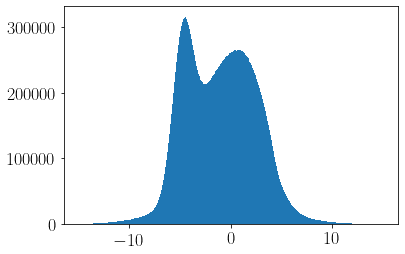

In [113]:
hist,bins = np.histogram(dparticles['p1']) 
plt.hist(dparticles['p1'], bins = binsplt) 
plt.show()

In [120]:
dparticles['p1'][105]

3.0744586

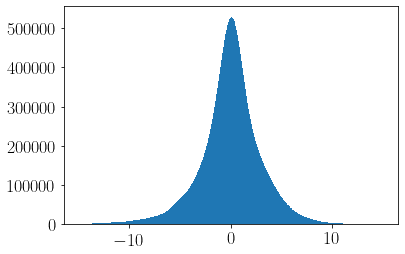

In [123]:
plt.hist(dparticles['p2'], bins = binsplt) 
plt.show()

In [94]:
#takes lorentz transform where V=(vx,0,0)
#TODO: check if units work (in particular where did gamma go)
def lorentz_transform_vx(dfields,vx):
    dfieldslor = copy(dfields) #deep copy
    
    dfieldslor['ex'] = dfields['ex']
    dfieldslor['ey'] = dfields['ey']-vx*dfields['bz']
    dfieldslor['ez'] = dfields['ez']+vx*dfields['by']
    dfieldslor['bx'] = dfields['bx']
    dfieldslor['by'] = dfiedls['by']#assume v/c^2 is small
    dfieldslor['bz'] = dfiedls['bz']#assume v/c^2 is small
    
    return dfieldslor

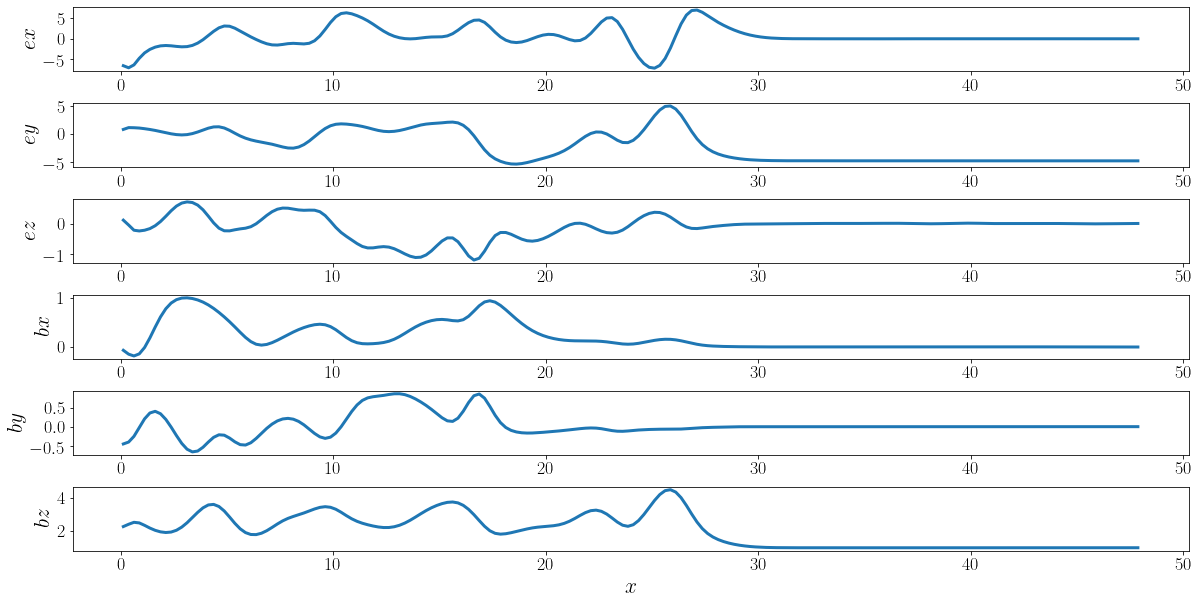

In [89]:
#plot fields before transform
plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [126]:
#takes lorentz transform where V=(vx,0,0)
#TODO: check if units work (in particular where did gamma go. Perhaps we just assume it's small)
def lorentz_transform_vx(dfields,vx):
    import copy
    dfieldslor = copy.copy(dfields) #deep copy
    
    dfieldslor['ex'] = dfields['ex']
    dfieldslor['ey'] = dfields['ey']-vx*dfields['bz']
    dfieldslor['ez'] = dfields['ez']+vx*dfields['by']
    dfieldslor['bx'] = dfields['bx']
    dfieldslor['by'] = dfields['by']#assume v/c^2 is small
    dfieldslor['bz'] = dfields['bz']#assume v/c^2 is small
    
    return dfieldslor

In [129]:
dfieldslor = lorentz_transform_vx(dfields,-5.0)

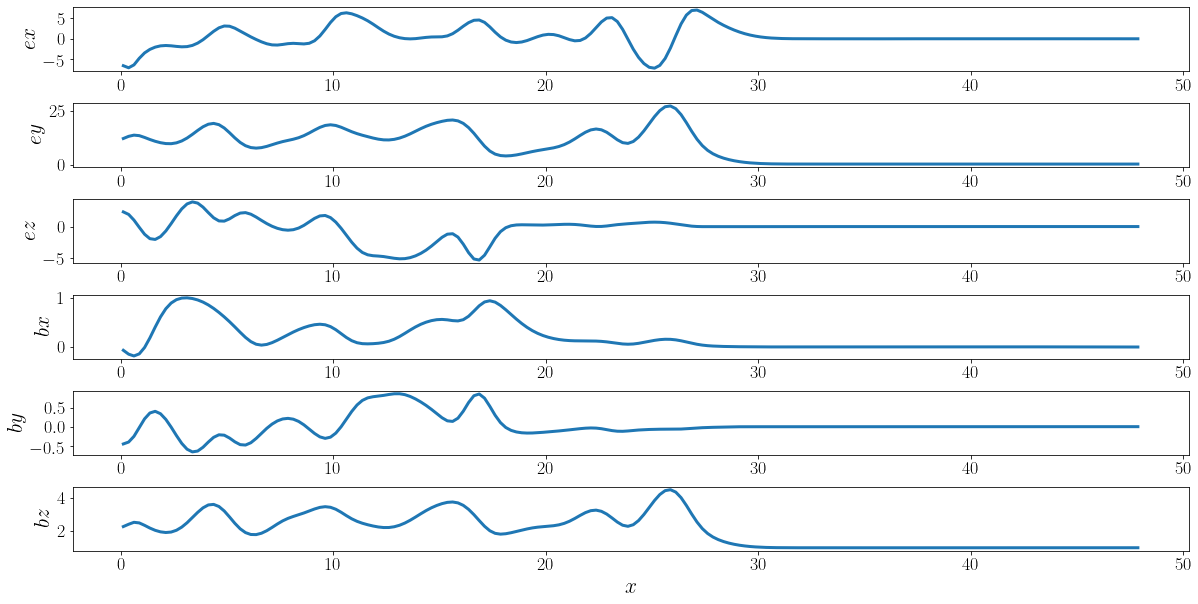

In [130]:
#plot fields before transform
plot_all_fields(dfieldslor, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [ ]:
get_bulk_flow(dparticles,2.5)

In [90]:
get_bulk_flow(readParticlesPosandVelocityOnly(path_particles, 1),2.5)

OSError: Unable to open file (unable to open file: name = 'FPC_Colby/run0/Output/Raw/Sp01/raw_sp01_00000001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [136]:
def getcompressionration(dfields,xShock):
    #find ratio of downstream bz and upstream bz
    bzsumdownstrm = 0.
    bzsumupstrm = 0. 
    
    for i in range(0,len(dfields['bz'])):
        for j in range(0,len(dfields['bz'][i])):
            for k in range(0,len(dfields['bz'][i][j])):
                if(dfields['bz_xx'][k] > xShock):
                    bzsumupstrm += dfields['bz'][i][j][k]
                else:
                    bzsumdownstrm += dfields['bz'][i][j][k]
                                      
    return bzsumdownstrm/bzsumupstrm
                                      
                

In [137]:
getcompressionration(dfields,xShock)

3.254928861140569

#### E cross B velocity

In [159]:
def plot_velsig_wEcrossB(vx,vy,vmax,Ce,ExBvx,ExBvy,fieldkey,flnm = '',ttl=''):
    plt.style.use("postgkyl.mplstyle") #sets style parameters for matplotlib plots

    maxCe = max(np.max(Ce),np.max(abs(Ce)))
    
    #ordering when plotting is flipped
    #see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html
    plotv1 = vx#np.flip(vx)
    plotv2 = vy#np.flip(vy)
    
    plt.figure(figsize=(6.5,6))
    plt.figure(figsize=(6.5,6))
    plt.pcolormesh(plotv1, plotv2, Ce, vmax=maxCe, vmin=-maxCe, cmap="seismic", shading="gouraud")
    plt.xlim(-vmax, vmax)
    plt.ylim(-vmax, vmax)
    plt.xticks(np.linspace(-vmax, vmax, 9))
    plt.yticks(np.linspace(-vmax, vmax, 9))
    plt.title(ttl+" $C($"+fieldkey+"$)(v_x, v_y)$",loc="right")
    plt.xlabel(r"$v_x/v_{ti}$")
    plt.ylabel(r"$v_y/v_{ti}$")
    plt.grid(color="k", linestyle="-", linewidth=1.0, alpha=0.6)
    clb = plt.colorbar(format="%.1f", ticks=np.linspace(-maxCe, maxCe, 8), fraction=0.046, pad=0.04) #TODO: make static colorbar based on max range of C
    plt.setp(plt.gca(), aspect=1.0)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.scatter([ExBvx],[ExBvy])
    #plt.savefig("CExxposindex"+str(xposindex)+".png", dpi=300) #TODO: rename
    if(flnm != ''):
        plt.savefig(flnm+'.png',format='png')
        plt.close('all')#saves RAM
    else:
        plt.show()
    plt.close()

In [145]:
def calc_E_crossB(dfields,x1,x2,y1,y2):
    exf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'ex')
    eyf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'ey')
    ezf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'ez')
    bxf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'bx')
    byf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'by')
    bzf = getfieldaverageinbox(0., 0., x1, x2, y1, y2, {}, dfields, 'bz')
    
    #E cross B / B^2
    magB = bxf**2.+byf**2.+bzf**2.
    ExBvx = (eyf*bzf-ezf*byf)/magB
    ExBvy = -1.*(exf*bzf-ezf*bxf)/magB
    ExBvz = (exf*bzf-ezf*bxf)/magB

    return ExBvx,ExBvy,ExBvz

In [143]:
#test ExB to see if we get reasonable numbers
xxindex = 50
yyindex = 0
zzindex = 0

exf = dfields['ex'][zzindex][yyindex][xxindex]
eyf = dfields['ey'][zzindex][yyindex][xxindex]
ezf = dfields['ez'][zzindex][yyindex][xxindex]
bxf = dfields['bx'][zzindex][yyindex][xxindex]
byf = dfields['by'][zzindex][yyindex][xxindex]
bzf = dfields['bz'][zzindex][yyindex][xxindex]

#E cross B / B^2
magB = bxf**2.+byf**2.+bzf**2.
ExBvx = (eyf*bzf-ezf*byf)/magB
ExBvy = -1.*(exf*bzf-ezf*bxf)/magB
ExBvz = (exf*bzf-ezf*bxf)/magB


print(ExBvx)
print(ExBvy)
print(ExBvz)

0.2972332435364193
-0.4718417523710572
0.4718417523710572


In [160]:
#make gif of ExB
xsweep=0.
for i in range(0,len(CEx_out)):
    print(str(i)+' of '+str(len(CEx_out)))
    ExBvx, ExBvy, ExBvz = calc_E_crossB(dfields, xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1])
    print(ExBvx)
    ttlCEx = 'graphsCExwithExB/'+'CEx'+str(i).zfill(3)
    ttlCEy = 'graphsCEywithExB/'+'CEy'+str(i).zfill(3)
    print(ttlCEx)
    plot_velsig_wEcrossB(vx,vy,vmax,CEx_out[i],ExBvx,ExBvy,'ex',flnm = ttlCEx,ttl='x(di): '+str(x_out[i]))
    plot_velsig_wEcrossB(vx,vy,vmax,CEy_out[i],ExBvx,ExBvy,'ey',flnm = ttlCEy,ttl='x(di): '+str(x_out[i]))
    xsweep+=dx

0 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.10568328795062604
graphsCExwithExB/CEx000
1 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.10563564329154472
graphsCExwithExB/CEx001
2 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.06355310557878129
graphsCExwithExB/CEx002
3 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.04071130269953805
graphsCExwithExB/CEx003
4 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.006896355644827941
graphsCExwithExB/CEx004
5 of 192
numgridpts sampled: 96
numgrid

numgridpts sampled: 96
-0.20369923702518627
graphsCExwithExB/CEx042
43 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.24865560444252435
graphsCExwithExB/CEx043
44 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.3144795751086192
graphsCExwithExB/CEx044
45 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.3900085188145924
graphsCExwithExB/CEx045
46 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.45991617761943276
graphsCExwithExB/CEx046
47 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-0.50747512755

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
0.10930840208837399
graphsCExwithExB/CEx085
86 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
0.29718118616927774
graphsCExwithExB/CEx086
87 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
0.4384004425390192
graphsCExwithExB/CEx087
88 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
0.5141011182757252
graphsCExwithExB/CEx088
89 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
0.5082761695313608
graphsCExwithExB/CEx089
90 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 

numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.778610157928546
graphsCExwithExB/CEx128
129 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.780138142690783
graphsCExwithExB/CEx129
130 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.780664108952568
graphsCExwithExB/CEx130
131 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.780526257878989
graphsCExwithExB/CEx131
132 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.780154883533998
graphsCExwithExB/CEx132
133 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sample

171 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.791446678743295
graphsCExwithExB/CEx171
172 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.790763597601272
graphsCExwithExB/CEx172
173 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.789977745211424
graphsCExwithExB/CEx173
174 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.789188722265862
graphsCExwithExB/CEx174
175 of 192
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
numgridpts sampled: 96
-4.788460810499304
graphsCExwithExB/CEx175
176 of 192
numgridpts sampled: 96
numgri

In [161]:
#make gif
import imageio
import os
images = []
directory = '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/testcolbyscript/graphsCExwithExB/'
filenames =  os.listdir(directory)
filenames = sorted(filenames)
filenames = filenames[1:] #quick way to remove .DS_store
for filename in filenames:
    images.append(imageio.imread(directory+filename))
imageio.mimsave('CExwithExB.gif', images)

In [163]:
#make gif
import imageio
import os
images = []
directory = '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/testcolbyscript/graphsCEywithExB/'
filenames =  os.listdir(directory)
filenames = sorted(filenames)
filenames = filenames[1:] #quick way to remove .DS_store
for filename in filenames:
    images.append(imageio.imread(directory+filename))
imageio.mimsave('CEywithExB.gif', images)

<img src="CExwithExB.gif" width="750" align="center">

<img src="CExwithExB.gif" width="750" align="center">

#### experiment with way to automatically estimate xshock

In [169]:
[dfields[fieldkey][zzindex][yyindex][i] for i in range(0,len(dfields[fieldkey+axis]))]

[-6.584533,
 -7.0923557,
 -6.385204,
 -4.7728043,
 -3.455435,
 -2.5925558,
 -2.0403926,
 -1.7311717,
 -1.6424127,
 -1.71821,
 -1.863971,
 -1.965962,
 -1.9137295,
 -1.6233469,
 -1.0554965,
 -0.22576043,
 0.78587854,
 1.8257998,
 2.678238,
 3.1282315,
 3.07124,
 2.58772,
 1.8869553,
 1.1560317,
 0.4703861,
 -0.16678458,
 -0.74512625,
 -1.2124887,
 -1.4912242,
 -1.5330968,
 -1.384197,
 -1.1917464,
 -1.1118674,
 -1.1798565,
 -1.2573266,
 -1.0995069,
 -0.48271605,
 0.68304956,
 2.2831047,
 3.9925275,
 5.3915596,
 6.1852374,
 6.357591,
 6.1092396,
 5.6556015,
 5.090913,
 4.4074607,
 3.5964715,
 2.7150502,
 1.8698397,
 1.1559063,
 0.61694,
 0.2514865,
 0.04256867,
 -0.023240676,
 0.037274797,
 0.18312606,
 0.34217387,
 0.43950725,
 0.4574716,
 0.48672453,
 0.70296043,
 1.2469201,
 2.0978029,
 3.073621,
 3.9493017,
 4.524589,
 4.5954485,
 4.0201697,
 2.9044979,
 1.6023213,
 0.4652992,
 -0.3376577,
 -0.78794134,
 -0.9217235,
 -0.78499216,
 -0.4369961,
 0.035204478,
 0.5196651,
 0.9013463,
 1.08